In [35]:
import pandas as pd
import matplotlib.pyplot as plt 



In [36]:
df = pd.read_csv('./sample_data/WAG_C_M.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WAG_C_M  284 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


#Визуальный анализ ряда


Text(0.5, 0, 'month')

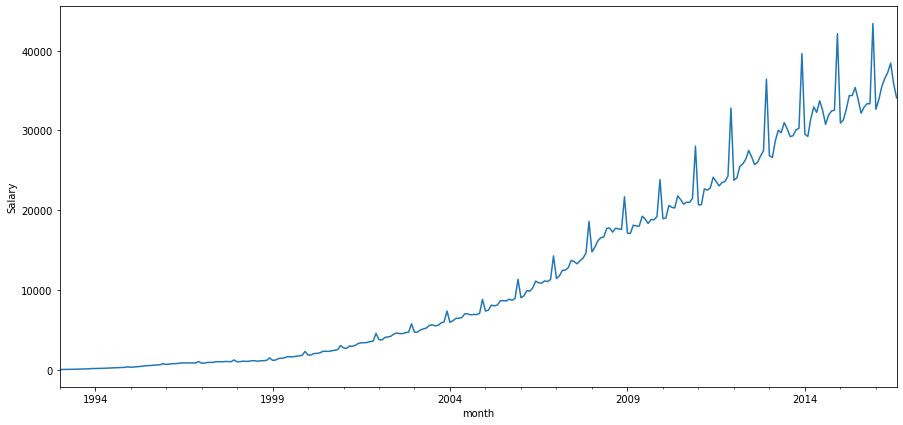

In [37]:
df.WAG_C_M.plot(figsize=(15,7))
plt.ylabel('Salary')
plt.xlabel('month')


In [38]:
import scipy.stats as sts
import statsmodels.api as sm

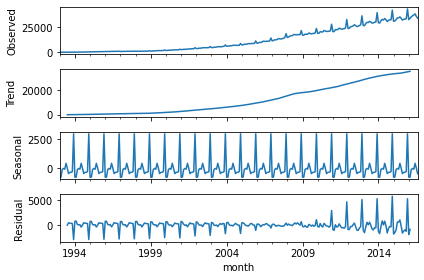

In [39]:
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
plt.show()

In [40]:
dfCriteria = sm.tsa.stattools.adfuller(df.WAG_C_M)[1]
'Критерий Дики-Фуллера:  p={0}'.format(dfCriteria)

'Критерий Дики-Фуллера:  p=0.9918495954854735'

# Стабилизация дисперсии


In [41]:
# Преобразование Бокса-Кокса
df['WAG_C_M_box'],lmda = sts.boxcox(df.WAG_C_M)
df,lmda

(            WAG_C_M  WAG_C_M_box
 month                           
 1993-01-01     15.3     3.990393
 1993-02-01     19.1     4.458758
 1993-03-01     23.6     4.931635
 1993-04-01     30.6     5.549430
 1993-05-01     37.5     6.063406
 ...             ...          ...
 2016-04-01  36497.0    56.526742
 2016-05-01  37270.0    56.860441
 2016-06-01  38447.0    57.358885
 2016-07-01  35888.0    56.260153
 2016-08-01  34095.0    55.455409
 
 [284 rows x 2 columns], 0.2632017541844584)

Критерий Дики-Фуллера:  p=0.6968987634832653


Text(0.5, 0, 'month')

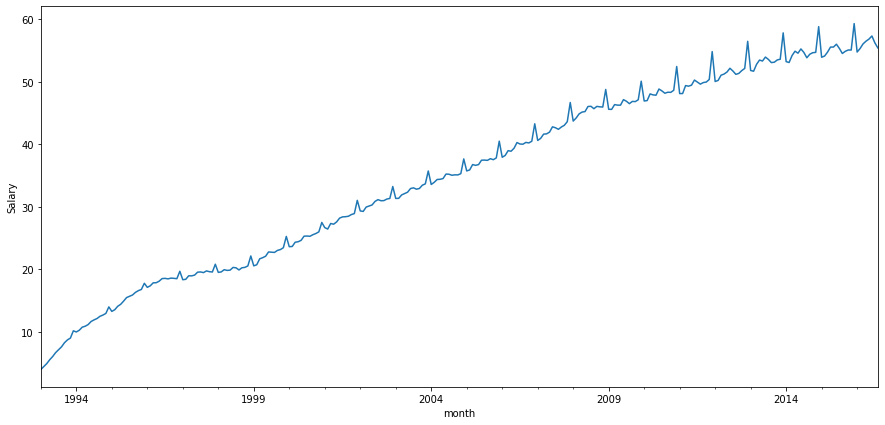

In [43]:
dfCriteria = sm.tsa.stattools.adfuller(df.WAG_C_M_box)[1]
print('Критерий Дики-Фуллера:  p={0}'.format(dfCriteria))
df.WAG_C_M_box.plot(figsize=(15,7))
plt.ylabel('Salary')
plt.xlabel('month')

# Выбор порядка дифференцирования

In [44]:
df['WAG_C_M_box_diff'] = df.WAG_C_M_box - df.WAG_C_M_box.shift(12);
df

,WAG_C_M,WAG_C_M_box,WAG_C_M_box_diff
month,,,
1993-01-01,15.3,3.990393,NaN
1993-02-01,19.1,4.458758,NaN
1993-03-01,23.6,4.931635,NaN
1993-04-01,30.6,5.549430,NaN
1993-05-01,37.5,6.063406,NaN
...,...,...,...
2016-04-01,36497.0,56.526742,0.942729
2016-05-01,37270.0,56.860441,1.275065
2016-06-01,38447.0,57.358885,1.316994


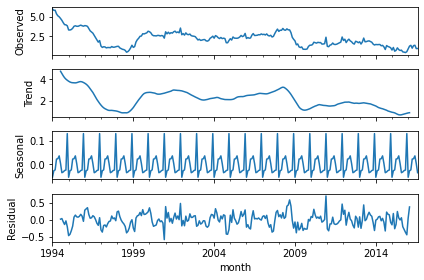

In [46]:
sm.tsa.seasonal_decompose(df.WAG_C_M_box_diff[12:]).plot()
plt.show()

In [47]:
dfCriteria = sm.tsa.stattools.adfuller(df.WAG_C_M_box_diff[12:])[1]
print('Критерий Дики-Фуллера:  p={0}'.format(dfCriteria))

Критерий Дики-Фуллера:  p=0.014697133494791808


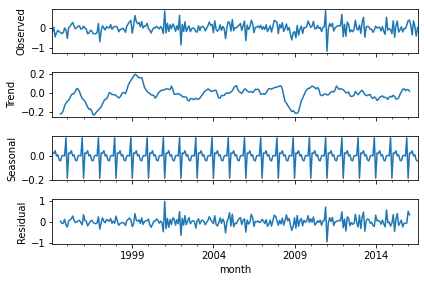

Критерий Дики-Фуллера:  p=5.203603715821631e-08


In [50]:
df['WAG_C_M_box_diff1'] = df.WAG_C_M_box_diff - df.WAG_C_M_box_diff.shift(1);
sm.tsa.seasonal_decompose(df.WAG_C_M_box_diff1[13:]).plot()
plt.show()
dfCriteria = sm.tsa.stattools.adfuller(df.WAG_C_M_box_diff1[13:])[1]
print('Критерий Дики-Фуллера:  p={0}'.format(dfCriteria))

$D=1, d=1$

# Выбор начальных приблежний параметров модели ARMA ($p,q,P,Q$)

(-0.2, 0.2)

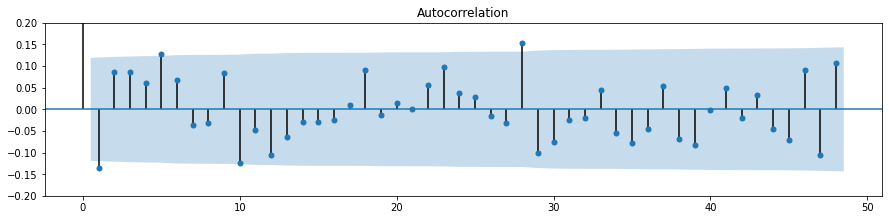

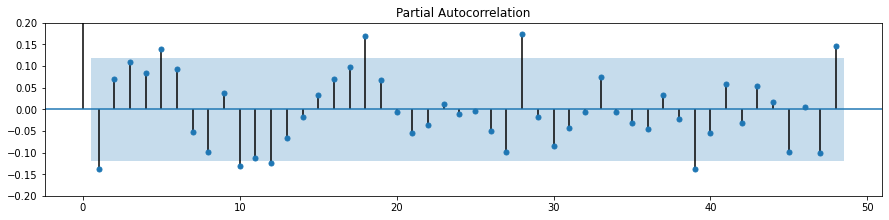

In [56]:
plt.figure(figsize=(15,7))
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df.WAG_C_M_box_diff1[13:].values.squeeze(), lags=48, ax=ax)
plt.ylim([-0.2, 0.2])

plt.figure(figsize=(15,7))
ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df.WAG_C_M_box_diff1[13:].values.squeeze(), lags=48, ax=ax)
plt.ylim([-0.2, 0.2])

$
Q=0, т.к. нет ниодного  значимого лага (не выходит за пределы в графике 1 среди каждых 12)

q=5 (самый длинныг лаг не сезонный 1-11)

P=4 (48, т.к. самый длинный 48-ой и делим на кол-во в сезоне, т.е. на 12)

p=10
$

In [58]:
from itertools import product
import warnings

In [68]:
d=1
D=1
Q= range(1)
P= range(2)
q=range(6)
p=range(6)

parameters = list(product(p,q,P,Q))
len(parameters)

72

# Обучение и сравнение моделей-кандидатов, выбор победителей

In [69]:
%%time

result = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for elem in parameters:
  model = sm.tsa.statespace.SARIMAX(df.WAG_C_M_box, order=(elem[0],d,elem[1]), seasonal_order=(elem[2], D, elem[3], 12)).fit(disp=-1)
  aic = model.aic

  if aic < best_aic:
    best_model = model
    best_aic = aic
    best_parameter = elem

  result.append([elem, aic])

warnings.filterwarnings('default')

CPU times: user 2min 58s, sys: 2min 10s, total: 5min 8s
Wall time: 2min 36s


In [70]:
df_result = pd.DataFrame(result, columns=['parameters', 'aic'])
df_result

,parameters,aic
0,"(0, 0, 0, 0)",5.241225
1,"(0, 0, 1, 0)",4.268898
2,"(0, 1, 0, 0)",3.369832
3,"(0, 1, 1, 0)",1.170768
4,"(0, 2, 0, 0)",2.182609
...,...,...
67,"(5, 3, 1, 0)",-14.477450
68,"(5, 4, 0, 0)",-15.634799
69,"(5, 4, 1, 0)",-13.597065
70,"(5, 5, 0, 0)",-22.286087


In [72]:
df_result.sort_values(by='aic').head(10)

,parameters,aic
71,"(5, 5, 1, 0)",-25.096169
59,"(4, 5, 1, 0)",-24.146169
70,"(5, 5, 0, 0)",-22.286087
28,"(2, 2, 0, 0)",-21.488595
29,"(2, 2, 1, 0)",-21.473461
30,"(2, 3, 0, 0)",-21.063239
31,"(2, 3, 1, 0)",-20.398608
40,"(3, 2, 0, 0)",-20.263386
41,"(3, 2, 1, 0)",-19.691255
32,"(2, 4, 0, 0)",-19.586581


In [73]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.548
Date:                            Thu, 26 Nov 2020   AIC                            -25.096
Time:                                    13:56:09   BIC                             18.129
Sample:                                01-01-1993   HQIC                            -7.741
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2174    357.037     -0.001      1.000    -699.997     699.562
ar.L2          0.2357    257.288      0.001      0.999    -504.040     504.512
ar.L3          0.4069    157.172      0.003      0.998    -307.645     308.459
ar.L4          0.0938    292.697      0.000      1.000    -573.582     573.770
ar.L5         -0.6332    241.071     -0.003      0.998    -473.123     471.857
ma.L1          0.0058    357.021   1.62e-05      1.000    -699.743     699.754
ma.L2         -0.1895    332.812     -0.001      1.000    -652.490     652.110
ma.L3         -0.2995    244.486     -0.001      0.999    -479.484     478.885
ma.L4          0.0681    336.271      0.000      1.000    -659.010     659.146
ma.L5          0.8925    339.731      0.003      0.998    -664.968     666.753
ar.S.L12      -0.1350      0.061     -2.224      0.026      -0.254      -0.016
sigma2         0.0483      0.004     12.903      0.000       0.041       0.056
===================================================================================
Ljung-Box (Q):                       26.14   Jarque-Bera (JB):                54.78
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Анализ остатков построенной модели

Критерий Дики-Фуллера:  p=2.5758945436252607e-29


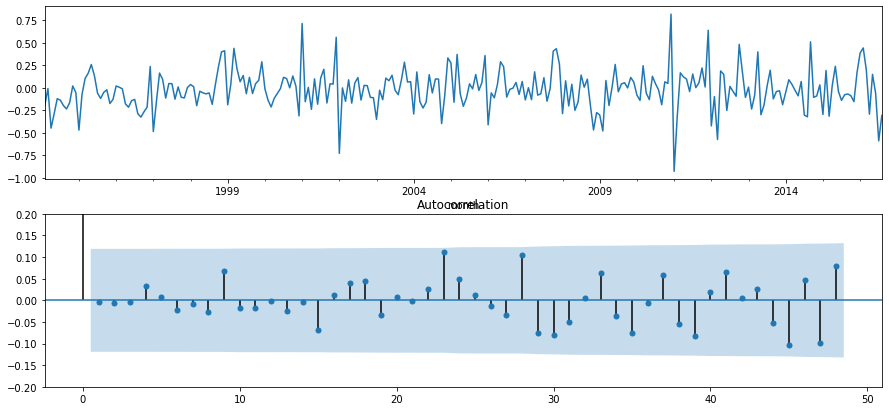

In [81]:
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
best_model.resid[13:].plot() 

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid[13:], lags=48, ax=ax)
plt.ylim([-0.2, 0.2])

dfCriteria = sm.tsa.stattools.adfuller(best_model.resid[13:])[1]
print('Критерий Дики-Фуллера:  p={0}'.format(dfCriteria))


In [82]:
import numpy as np

In [83]:
def inv_boxcox(y, lmbda):
  if lmbda == 0:
    return np.exp(y)

  return np.exp(np.log(lmbda * y + 1) / lmbda)

In [85]:
df['model'] = inv_boxcox(best_model.fittedvalues, lmda)
df

,WAG_C_M,WAG_C_M_box,WAG_C_M_box_diff,WAG_C_M_box_diff1,model
month,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,1.000000
1993-02-01,19.1,4.458758,NaN,NaN,15.300000
1993-03-01,23.6,4.931635,NaN,NaN,19.100000
1993-04-01,30.6,5.549430,NaN,NaN,23.600000
1993-05-01,37.5,6.063406,NaN,NaN,30.600000
...,...,...,...,...,...
2016-04-01,36497.0,56.526742,0.942729,-0.366210,37170.695617
2016-05-01,37270.0,56.860441,1.275065,0.332336,36920.930488
2016-06-01,38447.0,57.358885,1.316994,0.041929,38589.723620


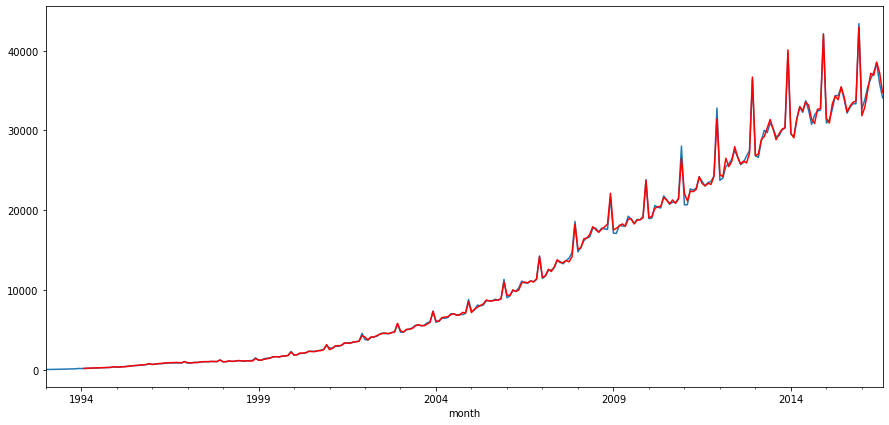

In [86]:
df.WAG_C_M.plot(figsize=(15,7))
df.model[13:].plot(color='r')

# Прогноз

In [87]:
df2 = df[['WAG_C_M']]
new_period = pd.date_range('2016-09-01', '2018-09-01', freq='MS')
new_period

DatetimeIndex(['2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [88]:
future = pd.DataFrame(index=new_period, columns=df2.columns)
df2 = pd.concat([df2,future])
df2

,WAG_C_M
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2018-05-01,NaN
2018-06-01,NaN
2018-07-01,NaN
2018-08-01,NaN


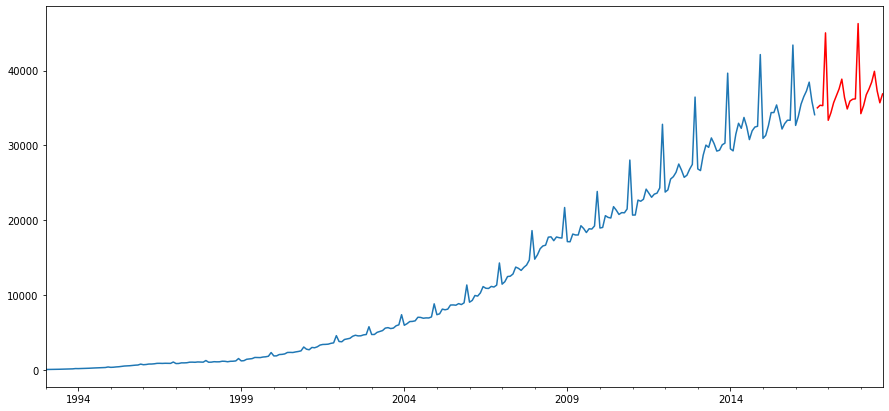

In [95]:
END=284+24
df2['forecast'] = inv_boxcox(best_model.predict(start=284, end=END), lmbda=lmda)
plt.figure(figsize=(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')